<a href="https://colab.research.google.com/github/HannahMohamed66/BNS/blob/main/Bayesian_Inference_for_spins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install -q bilby==2.2.2 matplotlib==3.7.3 dynesty==2.1.2 corner==2.2.2
!pip install gwpy

import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform, PowerLaw
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries


In [18]:
!pip install gwpy lalsuite

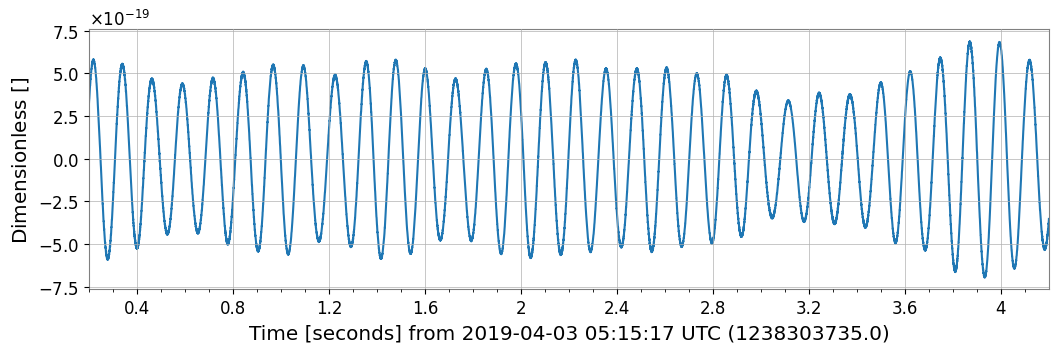

In [19]:
time_of_event = 1238303737.2
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

# Define times in relation to the trigger time (time_of_event), duration and post_trigger_duration
post_trigger_duration = 2
duration = 4
analysis_start = time_of_event + post_trigger_duration - duration

# Use gwpy to fetch the open data
H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

L1_analysis_data = TimeSeries.fetch_open_data(
    "L1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

H1_analysis_data.plot()
plt.show()


In [20]:
H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
L1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)

psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

L1_psd_data = TimeSeries.fetch_open_data(
    "L1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=L1_psd.frequencies.value, psd_array=L1_psd.value)


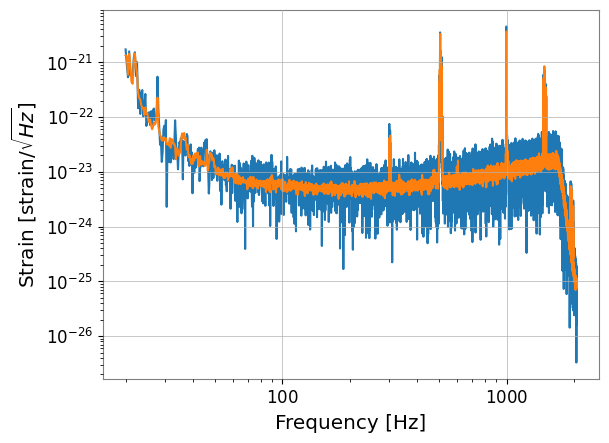

In [21]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

H1.maximum_frequency = 1024
L1.maximum_frequency = 1024


In [22]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=30.0, maximum=32.5)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
prior['a_1'] = Uniform(name='a_1', minimum=0, maximum=1)
prior['a_2'] = Uniform(name='a_2', minimum=0, maximum=1)
prior['tilt_1'] = Uniform(name='tilt_1', minimum=0, maximum=np.pi)
prior['tilt_2'] = Uniform(name='tilt_2', minimum=0, maximum=np.pi)
prior['phi_12'] = 0.0
prior['phi_jl'] = 0.0
prior['dec'] = -1.2232
prior['ra'] = 2.19432
prior['theta_jn'] = 1.89694
prior['psi'] = 0.532268
prior['luminosity_distance'] = PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000, unit='Mpc', latex_label='$d_L$')


In [23]:
# Put our "data" into a list of interferometers (the order is arbitrary)
interferometers = [H1, L1]

# Create a dictionary of arguments for the LALSimulation waveform
waveform_arguments = dict(
    waveform_approximant='IMRPhenomXP', reference_frequency=100., catch_waveform_errors=True)

# Create a waveform_generator object
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Create our likelihood
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=True)

result = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='spin_analysis', label="GW150914_spin",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    nlive=250, dlogz=1.,  # Arguments are used to make things fast - not recommended for general use
    clean=True,
)


15:58 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:58 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
15:58 bilby INFO    : Running for label 'GW150914_spin', output will be saved to 'spin_analysis'
15:58 bilby INFO    : Using lal version 7.5.0
15:58 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.22;Id: 5c23000593918e5e4ef2ff809eccc1722b5d0795;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
15:58 bilby INFO    : Using lalsimulation version 5.4.0
15:58 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.22;Id: 5c23000593918e5e4ef2ff809eccc1722b5d0795;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
15:58 bilby INFO    : Analysis priors

1it [00:00, ?it/s]

16:00 bilby INFO    : Written checkpoint file spin_analysis/GW150914_spin_resume.pickle
16:11 bilby INFO    : Written checkpoint file spin_analysis/GW150914_spin_resume.pickle
16:19 bilby INFO    : Written checkpoint file spin_analysis/GW150914_spin_resume.pickle
16:19 bilby INFO    : Rejection sampling nested samples to obtain 191 posterior samples
16:19 bilby INFO    : Sampling time: 0:20:45.124492
16:19 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/191 [00:00<?, ?it/s]

16:20 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/191 [00:00<?, ?it/s]

16:20 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/191 [00:00<?, ?it/s]

16:20 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/191 [00:00<?, ?it/s]

16:20 bilby INFO    : Summary of results:
nsamples: 191
ln_noise_evidence: -8291.985
ln_evidence: -8282.311 +/-  0.233
ln_bayes_factor:  9.674 +/-  0.233



In [24]:
result.posterior

a_1 = result.posterior["a_1"].values
a_2 = result.posterior["a_2"].values
tilt_1 = result.posterior["tilt_1"].values
tilt_2 = result.posterior["tilt_2"].values

a_1_lower_bound = np.quantile(a_1, 0.05)
a_1_upper_bound = np.quantile(a_1, 0.95)
a_1_median = np.quantile(a_1, 0.5)

a_2_lower_bound = np.quantile(a_2, 0.05)
a_2_upper_bound = np.quantile(a_2, 0.95)
a_2_median = np.quantile(a_2, 0.5)

tilt_1_lower_bound = np.quantile(tilt_1, 0.05)
tilt_1_upper_bound = np.quantile(tilt_1, 0.95)
tilt_1_median = np.quantile(tilt_1, 0.5)

tilt_2_lower_bound = np.quantile(tilt_2, 0.05)
tilt_2_upper_bound = np.quantile(tilt_2, 0.95)
tilt_2_median = np.quantile(tilt_2, 0.5)

print("a_1 = {} with a 90% C.I = {} -> {}".format(a_1_median, a_1_lower_bound, a_1_upper_bound))
print("a_2 = {} with a 90% C.I = {} -> {}".format(a_2_median, a_2_lower_bound, a_2_upper_bound))
print("tilt_1 = {} with a 90% C.I = {} -> {}".format(tilt_1_median, tilt_1_lower_bound, tilt_1_upper_bound))
print("tilt_2 = {} with a 90% C.I = {} -> {}".format(tilt_2_median, tilt_2_lower_bound, tilt_2_upper_bound))


a_1 = 0.7454727709624942 with a 90% C.I = 0.19405628192292818 -> 0.9736133159106614
a_2 = 0.6992765786136761 with a 90% C.I = 0.11390668396790937 -> 0.9767473855079195
tilt_1 = 0.8399954600143124 with a 90% C.I = 0.16791625460352394 -> 1.9210922358214801
tilt_2 = 1.4369368343361246 with a 90% C.I = 0.4528019730052727 -> 2.76875151585037


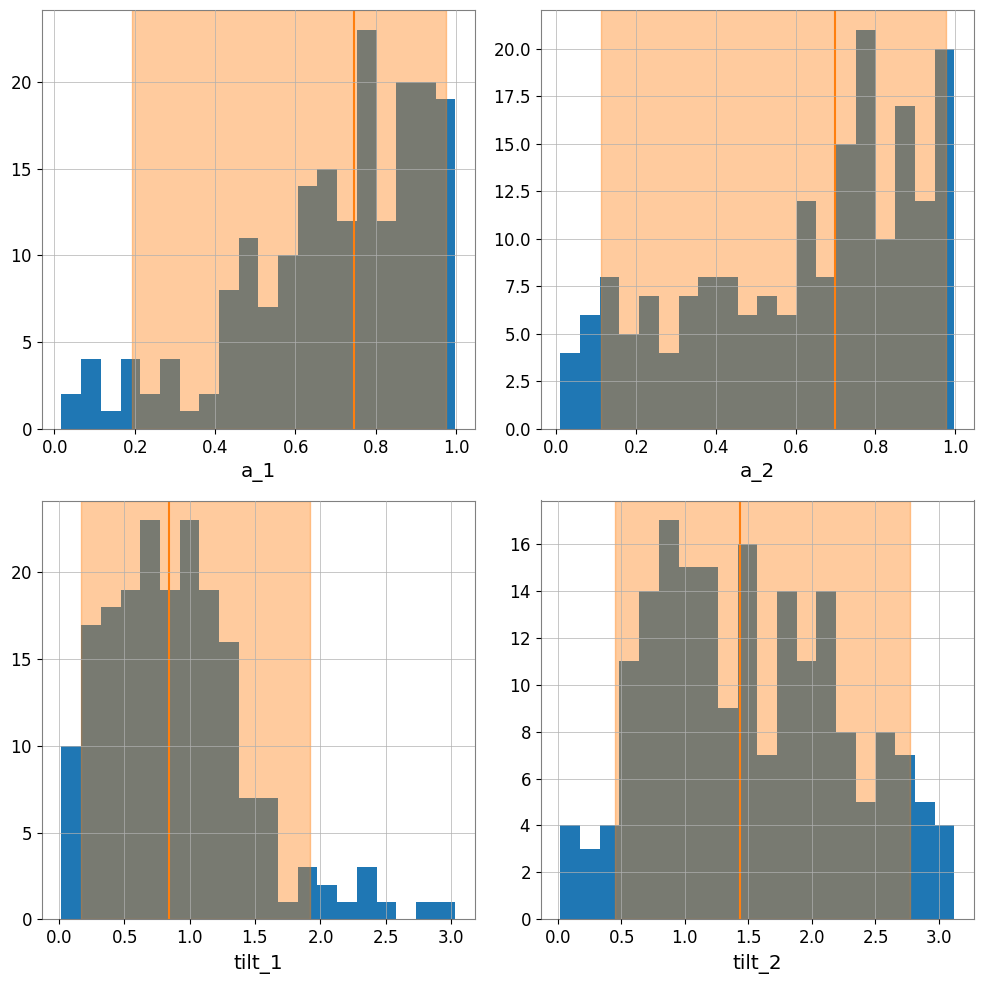

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].hist(a_1, bins=20)
ax[0, 0].axvspan(a_1_lower_bound, a_1_upper_bound, color='C1', alpha=0.4)
ax[0, 0].axvline(a_1_median, color='C1')
ax[0, 0].set_xlabel("a_1")

ax[0, 1].hist(a_2, bins=20)
ax[0, 1].axvspan(a_2_lower_bound, a_2_upper_bound, color='C1', alpha=0.4)
ax[0, 1].axvline(a_2_median, color='C1')
ax[0, 1].set_xlabel("a_2")

ax[1, 0].hist(tilt_1, bins=20)
ax[1, 0].axvspan(tilt_1_lower_bound, tilt_1_upper_bound, color='C1', alpha=0.4)
ax[1, 0].axvline(tilt_1_median, color='C1')
ax[1, 0].set_xlabel("tilt_1")

ax[1, 1].hist(tilt_2, bins=20)
ax[1, 1].axvspan(tilt_2_lower_bound, tilt_2_upper_bound, color='C1', alpha=0.4)
ax[1, 1].axvline(tilt_2_median, color='C1')
ax[1, 1].set_xlabel("tilt_2")

plt.tight_layout()
plt.show()


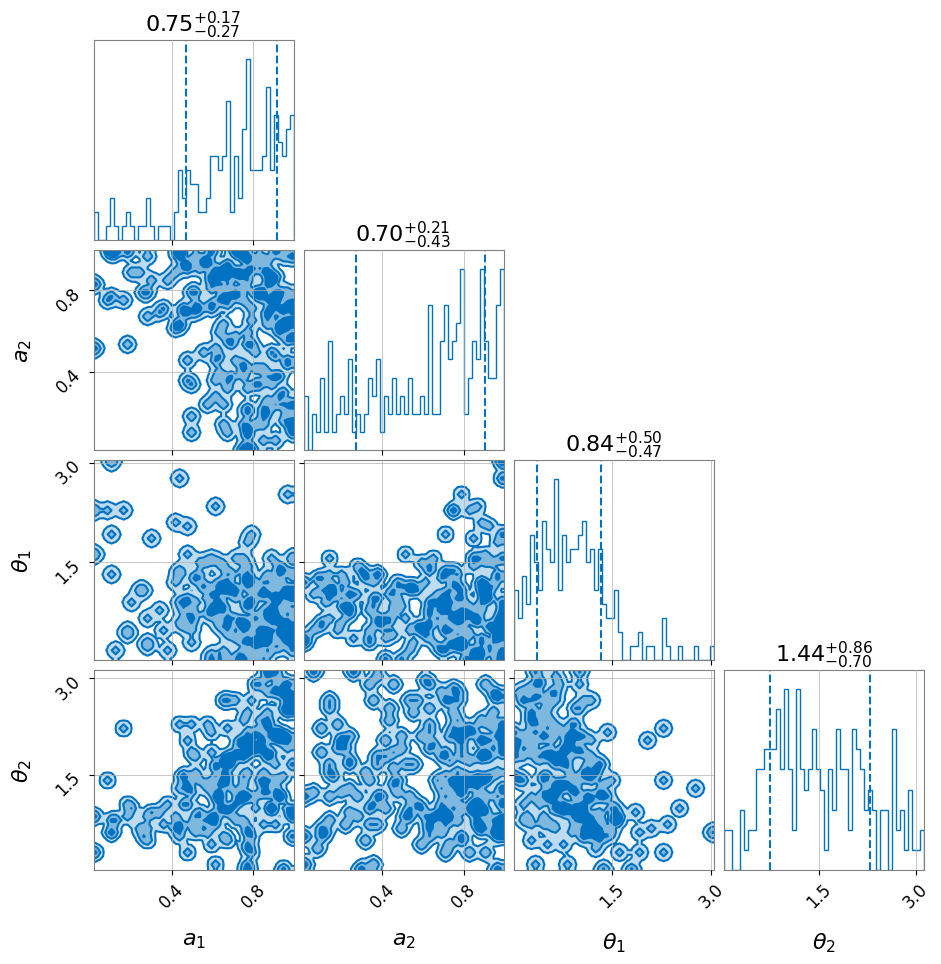

In [26]:
result.plot_corner(parameters=["a_1", "a_2", "tilt_1", "tilt_2"], prior=True)
